In [2]:
import numpy as np 
import scipy.optimize as opt
import matplotlib.pyplot as plot
import os

In [25]:
def load_data(folder_path, date, file_ID):
    
    
    file_name = folder_path + file_ID 
    # Load data from file and perfrom a mean of the value. 
    data = np.loadtxt(file_name + '.dat')
    
    mean_data = np.mean(data, axis=0)
    # load data from params file. 
    params_file = folder_path + file_ID + 'Params' + '.dat'
    params = np.loadtxt(params_file, delimiter = '\t', usecols = 1)
    
    start = params[0]
    stop = params[1]
#   step = params[2]*0.001
    no_of_steps = len(mean_data)
   
    # Creates a variable containing the applied frequencies. 
    if start < stop:
        freq = np.linspace(start, stop, no_of_steps)
    else:
        freq = np.linspace(stop, start, no_of_steps)
        mean_data = mean_data[::-1]
    
    mean_data = mean_data/np.mean(mean_data[0:20])
    
    return(freq, mean_data, data)   

In [4]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig, ax = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax.scatter(freq, mean_data, marker = 'x',color = 'r', label = "Experiment Data")
    
    return(fig, ax)

In [27]:
def Analysis(freq, mean_data):    
    end_point = int(len(mean_data))
    #   Determines the mean fluorescenet baseline signal. 
    fluor_baseline = np.mean(mean_data[int(np.floor(0.9*end_point)):end_point])
    fluor_min = np.min(mean_data)

    # First guesses for the curve fittings
#    A = (fluor_min-fluor_baseline)*0.1
#    x0 = 2.89
#    gamma = 0.001
#    offset = fluor_baseline
#    A2 = (fluor_min-fluor_baseline)*0.1
#    x02 = 2.86
#    gamma2 = 0.001

    A = 1
    x0 = 2.89
    gamma = 0.001
    offset = 1 
    A2 = 1
    x02 = 2.86
    gamma2 = 0.001


#    P1 = [A, x0, gamma, offset]
    P2 = [A, x0, gamma, A2, x02, gamma2, offset]
   
#    x, y, opt_error, contrast, contrast_error = single_peak(freq, mean_data, P1)
    analysis = multi_peak(freq, mean_data, P2)

    return(analysis)

In [6]:
def single_peak(freq, mean_data, P1):
    # Apply curve fitting optimisation 
#    coeffs, confidence = opt.curve_fit(gaussian, freq, mean_data, P1)    
    coeffs, confidence = opt.curve_fit(lorentz, freq, mean_data, P1)
    opt_error = np.sqrt(np.diag(confidence))
    
    x = np.linspace(np.min(freq), np.max(freq), 1000)
    # Generate fit. 
#    y = gaussian(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3])
    y = lorentz(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3])  
    
    contrast = (1-(np.min(mean_data)/coeffs[4]))*100
    contrast_error = (np.sqrt(coeffs[4])/coeffs[4])*contrast

    return(x, y, coeffs, opt_error, contrast, contrast_error)

In [22]:
def multi_peak(freq, mean_data, P2):
    # Apply curve fitting optimisation 
#    coeffs, confidence = opt.curve_fit(gaussian_2, freq, mean_data, P0)
    coeffs, confidence = opt.curve_fit(lorentz_2, freq, mean_data, P2)
    opt_error = np.sqrt(np.diag(confidence))
    
    x = np.linspace(np.min(freq), np.max(freq), 1000)
    y = gaussian_2(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3],coeffs[4], coeffs[5], coeffs[6])
#    y = lorentz_2(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6])
   
    #caculate applied B field\zero field splitting        
    hbar = 6.62*10**(-34)
    MuB = 9.24*10**(-24)
    ge = 2.002  
    
    splitting = (coeffs[4]-coeffs[1])*1000 
    print(splitting)
    B_Field = (splitting*10**6*hbar)/(2*ge*MuB)
    print(B_Field)
    
    contrast = (1-(np.min(mean_data)/coeffs[6]))*100
    contrast_error = (np.sqrt(coeffs[6])/coeffs[6])*contrast
    
    return([x, y, coeffs, opt_error, splitting, B_Field, contrast, contrast_error])

In [8]:
def plot_fitting(ax, x, y):    
    #Plot  fit and complete graph
    plot.plot(x,y, color = 'k', linewidth = 2.0, label = "Double Gaussian curve fitting")
    ax.set_xlabel('Microwave Frequency  (GHz)')
    ax.set_ylabel('Counts (per int. time)')
    #axes = plot.gca()
    ax.set_xlim(np.min(x), np.max(x))
#    axes.set_ylim(0.985*np.min(y), 1.02*np.max(y))
    ax.legend(loc = 'lower right')
    return(ax)

In [9]:
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset  

In [10]:
def gaussian_2(x, height, center, width, height2, center2, width2, offset):
    # P0[0] = Amplitude 1, P0[1] = Resonance 1, P0[2] = FWHM 1
    # P0[3] = Amplitude 2, P0[4] = Resonance 2, P0[5] = FWHM 2, P0[6] = offset
    
    first_peak = height*np.exp(-(x - center)**2/(2*width**2))
    second_peak = height2*np.exp(-(x - center2)**2/(2*width2**2)) 
    return first_peak + second_peak + offset 


In [11]:
def lorentz(x, A, x0, gamma, D):
    return (A/np.pi) *(gamma/((x-x0)**2)+gamma**2) + D


In [12]:
def lorentz_2(x, A1, X01, sig1, A2, X02, sig2, offset):#P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # P0[0] = Amplitude 1, P0[1] = Resonance 1, P0[2] = FWHM 1
    # P0[3] = Amplitude 2, P0[4] = Resonance 2, P0[5] = FWHM 2, P0[6] = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return first_peak + second_peak + offset


In [13]:
def save_data(date, file_ID, contrast, contrast_error, coeffs, opt_error):
    
    destination_folder = 'H:\\My Documents\\Strathclyde\\Graphs_and_analysis\\ODMR\\' + date + '\\'
    output_data_file = destination_folder + date + '_NVScan_analysis.dat'
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  ', \t' + 'Max Contrast (%)' + '\t' + 'Contrast error (%)' + '\t' + 
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ', \t' +  str(contrast) + ", \t"  + str(contrast_error) +
                 ", \t"  + str(coeffs[1]) + ", \t"  + str(opt_error[1]) +
                 ", \t"  + str(coeffs[4]) + ", \t"  + str(opt_error[4]) +
                 ", \t" +  str(coeffs[2]*1000) + ", \t" + str(opt_error[2]*1000) + ", \t" + 
                 str(coeffs[5]*1000) + ", \t" + str(opt_error[5]*1000) + '\n')
    # Saving a plot of the raw data to a folder. 
    plot.savefig(destination_folder + file_ID + '.png', transparent = True)    
    
  

30.503298653220323
0.0005458065664971354


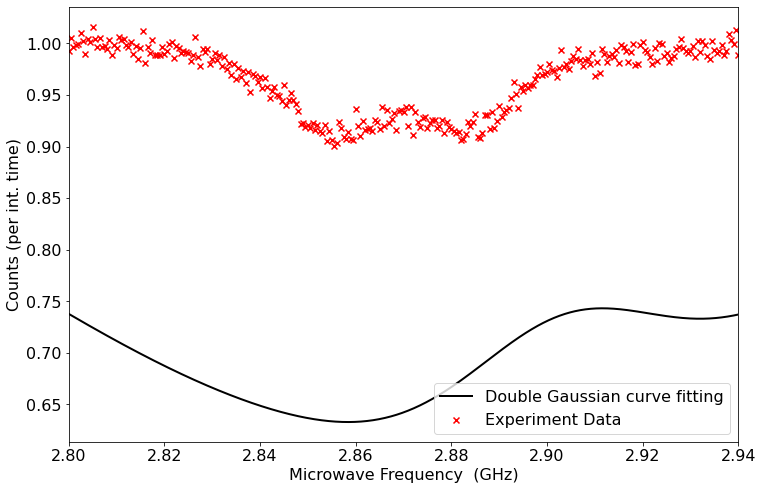

In [28]:
# Create folder and file name
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Thermometry\\20200124\\Scan1\\'
date = '20200124'
file_ID1 = '20200124_Thermometry_Scan1_29'

freq, mean_data, data = load_data(folder_path, date, file_ID1)
fig, ax = scatter_plot(freq, mean_data)
analysis = Analysis(freq, mean_data)
plot_fitting(ax, analysis[0], analysis[1])
#save_data(date, fileID, analysis[6], analysis[7], analysis[2], analysis[3])  